In [10]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import tempfile
from ray import train
from pathlib import Path
import os
from torch.utils.data import WeightedRandomSampler, DataLoader
%matplotlib inline

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

root_dir = os.path.abspath("./Splits")
train_dataset = datasets.ImageFolder(root=os.path.join(root_dir, "train"), transform=my_transform)
class_weights = []

for root, subdir, files in os.walk(os.path.join(root_dir, "train")):
    if len(files) > 0:
        class_weights.append(1 / len(files))
    
sample_weights = [0] * train_dataset.__len__()

for idx, (data, label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

test_dataset = datasets.ImageFolder(root=os.path.join(root_dir, "test"), transform=my_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(root_dir, "val"), transform=my_transform)

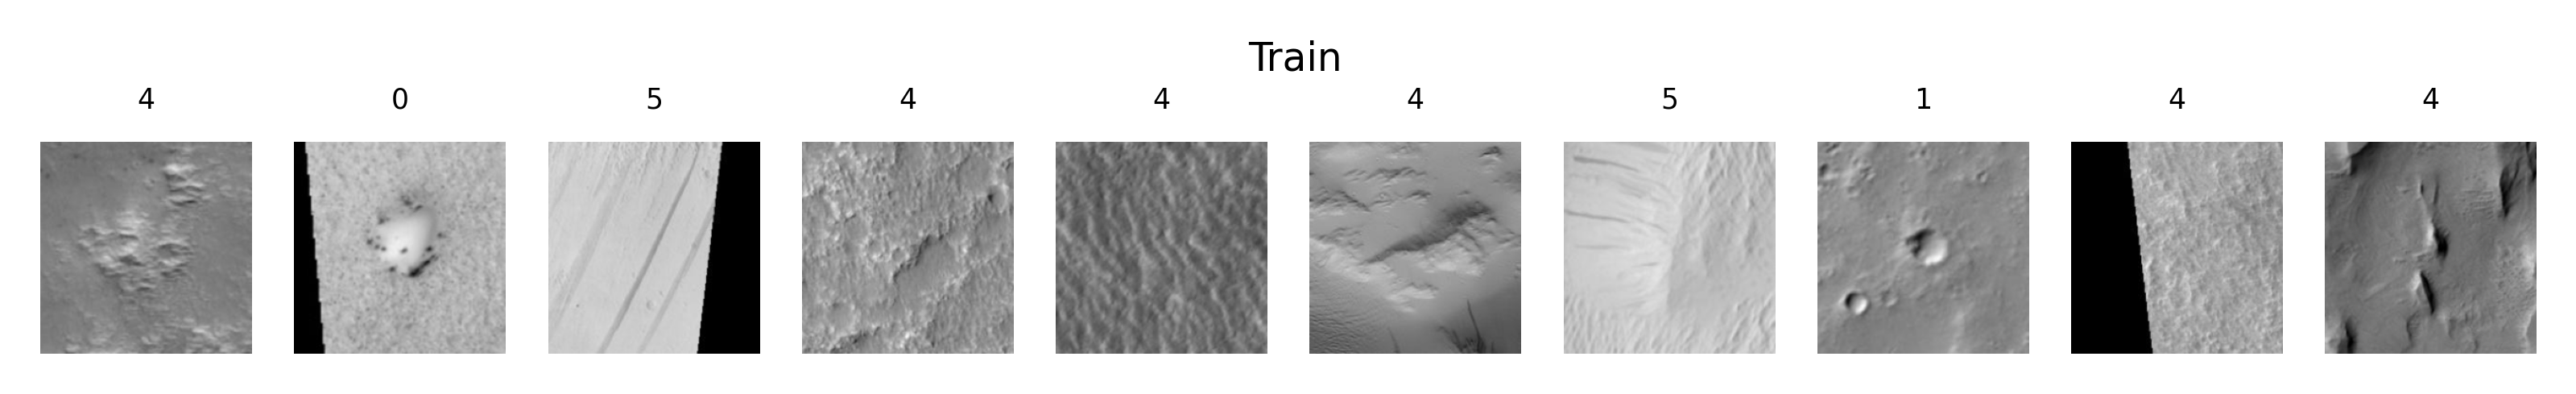

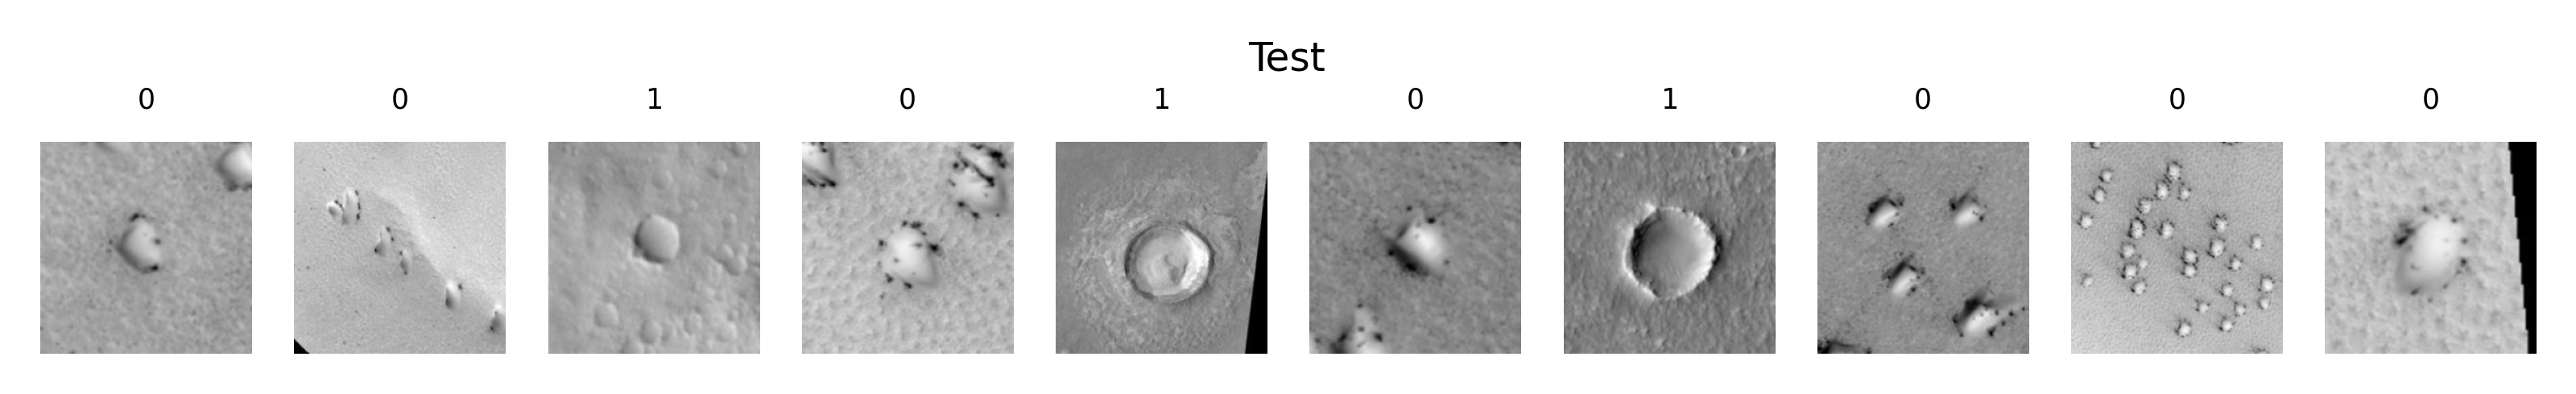

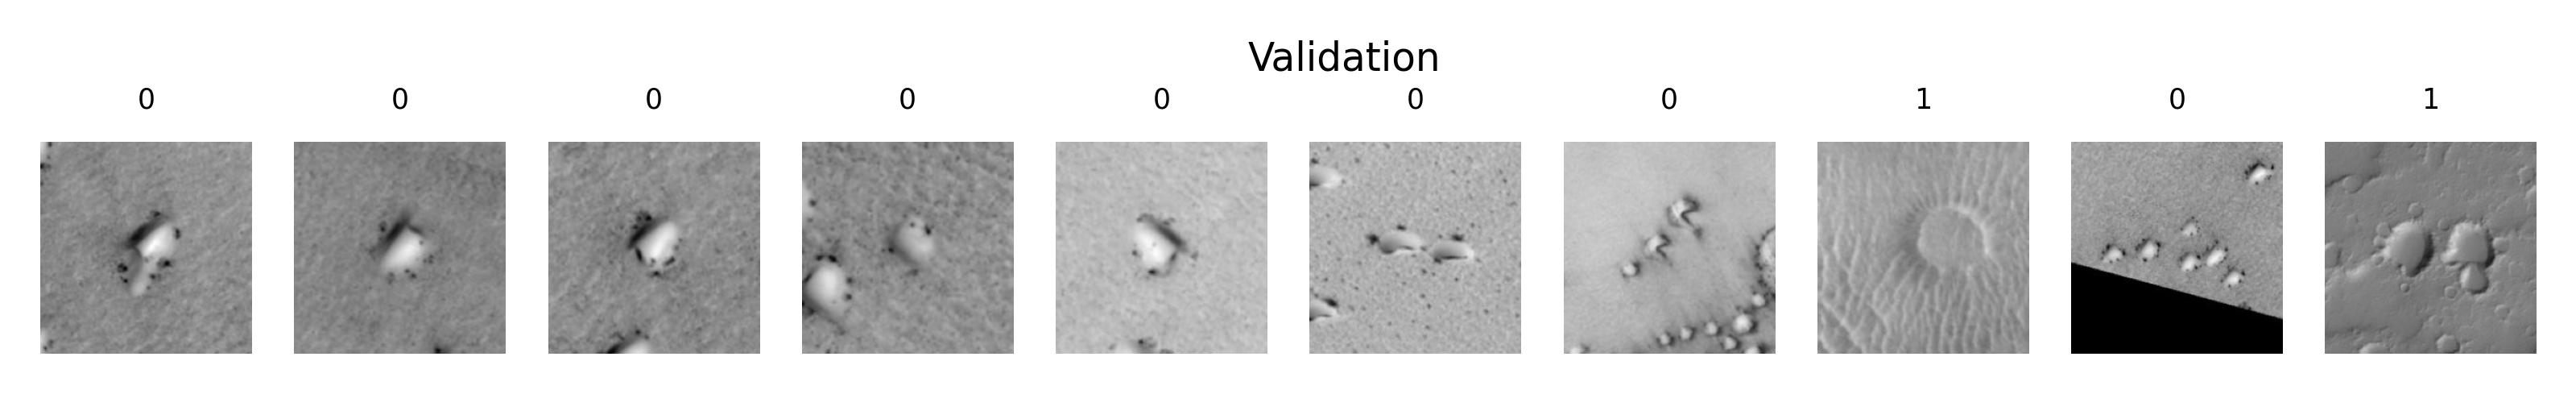

In [13]:
def show_images(split, title):
    fig = plt.figure(figsize=(8, 8), dpi=500)
    cols, rows = 10, 1
    
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(split), size=(1,)).item()
        img, label = split[sample_idx]
        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(f"{label}", fontsize=5, )

    fig.text(0.5, y=0.55, s=title, fontsize=7)
    plt.show()

show_images(train_dataset, title='Train')
show_images(test_dataset,  title='Test')
show_images(val_dataset,  title='Validation')

Image size after convolution operation:
$$
\frac{(w/h - k + 2p)}{s} + 1
$$

In [14]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))


        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.droupout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=512 * 7 * 7, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=8)


    def forward(self, x):
        x = self.pool(self.conv1_2(self.conv1_1(x)))
        x = self.pool(self.conv2_2(self.conv2_1(x)))
        x = self.pool(self.conv3_3(self.conv3_2(self.conv3_1(x))))
        x = self.pool(self.conv4_3(self.conv4_2(self.conv4_1(x))))
        x = self.pool(self.conv5_3(self.conv5_2(self.conv5_1(x))))
        x = self.droupout(self.relu(self.fc1(x.view(x.shape[0], -1))))
        x = self.droupout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [15]:
cnn = CNN()
cnn

CNN(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512,

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32)
for inp, label in train_loader:
    out = cnn(inp)
    break

In [8]:
def train_model(config):
    cnn = CNN()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            cnn = nn.DataParallel(cnn)
            
    cnn = CNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=config["lr"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            model_state, optimizer_state = torch.load(
                Path(checkpoint_dir) / "checkpoint.pt"
            )

            cnn.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), sampler=sampler, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnn(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = Path(temp_checkpoint_dir) / "checkpoint.pt"
            torch.save(
                (cnn.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps, "accuracy": correct / total},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [9]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64])
}

In [18]:
gpus_per_trial = 0.0
num_samples = 1
max_num_epochs = 1

scheduler = ASHAScheduler(
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2,
)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_model),
        resources={"cpu": 12, "gpu": gpus_per_trial}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples
    ),
    param_space=config
)

result = tuner.fit()

2024-08-23 12:03:46,224	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-08-23 12:03:46,231	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/aniat/ray_results/train_model_2024-08-23_12-02-47' in 0.0066s.
2024-08-23 12:03:56,457	INFO tune.py:1041 -- Total run time: 57.45 seconds (47.12 seconds for the tuning loop).
2024-08-23 12:03:56,457	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/aniat/ray_results/train_model_2024-08-23_12-02-47", trainable=...)
2024-08-23 12:03:56,647	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 9 trial(s):
- train_model_592e6_00001: FileNotFoundError('Could not fetch metrics for train_model_592e6_00001: both result.json and progre

In [ ]:
def test_accuracy(net, device="cpu"):

    testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

Best trial config: {'l1': 32, 'l2': 16, 'lr': 0.0014303463571719607, 'batch_size': 16}
Best trial final validation loss: 0.04647514249412294
Best trial final validation accuracy: 0.9870833333333333


In [ ]:
best_trained_model = CNN(best_trial.config["l1"], best_trial.config["l2"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=270, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
    test_acc = test_accuracy(best_trained_model, device)
    print(f"Best trial test set accuracy: {test_acc}")

Best trial test set accuracy: 0.9875
